In this analysis, we'll examine patient treatment data to determine whether certain treatments are significantly more expensive than others. The dataset includes four types of diagnoses: COVID-19, FLU, Fracture, and Routine Checkup. Since diagnosis type can significantly affect doctor fees, we'll focus our analysis on a single diagnosis to isolate the effect of treatment type on cost.

**Our Research Question:** For patients with fracture diagnoses, is surgery significantly more expensive than therapy?

To answer this question, we'll use three statistical methods:

- **Shapiro-Wilk Test**: To assess whether the data follows a normal distribution
- **Levene's Test**: To check whether groups have similar variance (homogeneity of variance)
- **T-test**: To compare group means, using either Student's t-test or Welch's t-test depending on our assumptions

## Data Loading and Initial Exploration

Let's start by importing the necessary libraries and loading our dataset.

In [1]:
# Import required libraries and load data
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, levene, ttest_ind
# Load the dataset
df = pd.read_excel('data/medical_visits_AB.xlsx')

In [2]:
df.head()

,visit_id,patient_id,visit_date,diagnosis,treatment,doctor_fee
0,20000,1335,2023-01-01,Fracture,Medication,78.31
1,20001,1423,2023-01-02,COVID-19,Vaccination,68.53
2,20002,1084,2023-01-03,Fracture,Medication,103.28
3,20003,1388,2023-01-04,Fracture,Therapy,182.64
4,20004,1122,2023-01-05,Fracture,Vaccination,73.41


Now let's filter our dataset to focus only on patients with fracture diagnoses, as mentioned in our research question.

Let's first explore the data to see the distribution of diagnoses and treatments in our dataset.

In [3]:
df[['diagnosis', 'treatment', 'patient_id']].groupby(['diagnosis', 'treatment']).count()

patient_id
diagnosis       treatment              
COVID-19        Medication           46
                Observation          50
                Surgery              52
                Therapy              51
                Vaccination          57
Flu             Medication           38
                Observation          48
                Surgery              43
                Therapy              41
                Vaccination          43
Fracture        Medication           46
                Observation          52
                Surgery              49
                Therapy              56
                Vaccination          37
Routine Checkup Medication           49
                Observation          62
                Surgery              48
                Therapy              42
                Vaccination          40

In [4]:
df = df[df['diagnosis'] == 'Fracture']
df.head()

,visit_id,patient_id,visit_date,diagnosis,treatment,doctor_fee
0,20000,1335,2023-01-01,Fracture,Medication,78.31
2,20002,1084,2023-01-03,Fracture,Medication,103.28
3,20003,1388,2023-01-04,Fracture,Therapy,182.64
4,20004,1122,2023-01-05,Fracture,Vaccination,73.41
8,20008,1457,2023-01-09,Fracture,Therapy,198.13


## Step 1: Checking Data Normality

Before we can perform a t-test, we need to verify that our data meets the assumptions required for parametric testing. The t-test assumes that the data is normally distributed. Let's first examine the distribution of treatments in our filtered dataset, then test for normality using the Shapiro-Wilk test.

In [5]:
# Examine treatment distribution
treatment_counts = df['treatment'].value_counts()
print(treatment_counts)

treatment
Therapy        56
Observation    52
Surgery        49
Medication     46
Vaccination    37
Name: count, dtype: int64


## Shapiro-Wilk Test

In [6]:
import pandas as pd
from scipy.stats import shapiro

def check_normality_by_group(df, group_col, value_col, alpha=0.05, min_n=3):
    """
    Check normality of `value_col` within each level of `group_col`
    using the Shapiro–Wilk test.

    Returns a DataFrame with:
      group, n, stat, p_value, normality_met
    """
    results = []

    for group_name, group_df in df.groupby(group_col):
        values = group_df[value_col].dropna()

        n = len(values)
        if n < min_n:
            # Not enough data to meaningfully test normality
            results.append({
                "group": group_name,
                "n": n,
                "stat": None,
                "p_value": None,
                "normality_met": None
            })
            continue

        stat, p = shapiro(values)

        results.append({
            "group": group_name,
            "n": n,
            "stat": stat,
            "p_value": p,
            "normality_met": p > alpha
        })

    return pd.DataFrame(results)


In [7]:
normality_result = check_normality_by_group(
    df,
    group_col="treatment",
    value_col="doctor_fee",
    alpha=0.05
)

print(normality_result)


         group   n      stat   p_value  normality_met
0   Medication  46  0.987583  0.899786           True
1  Observation  52  0.985473  0.772820           True
2      Surgery  49  0.990907  0.967362           True
3      Therapy  56  0.968323  0.147227           True
4  Vaccination  37  0.947847  0.082256           True


### Visual Assessment of Normality

In addition to statistical tests, let's visualize the distributions to get an intuitive sense of whether they appear normal.

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_histogram_by_group(
    df,
    group_col="treatment",
    value_col="doctor_fee",
    bins=30,
    log_scale=False,
    figsize=(12, 5)
):
    """
    Plot histograms of value_col for each group in group_col
    to visually assess normality.
    """

    groups = df[group_col].dropna().unique()
    n_groups = len(groups)

    fig, axes = plt.subplots(1, n_groups, figsize=figsize, sharey=True)

    if n_groups == 1:
        axes = [axes]

    for ax, g in zip(axes, groups):
        values = df[df[group_col] == g][value_col].dropna()

        sns.histplot(values, bins=bins, kde=True, ax=ax)
        ax.set_title(f"{group_col} = {g}\n(n = {len(values)})")
        ax.set_xlabel(value_col)

        if log_scale:
            ax.set_xscale("log")

    plt.suptitle(f"Histogram of {value_col} by {group_col}")
    plt.tight_layout()
    plt.show()


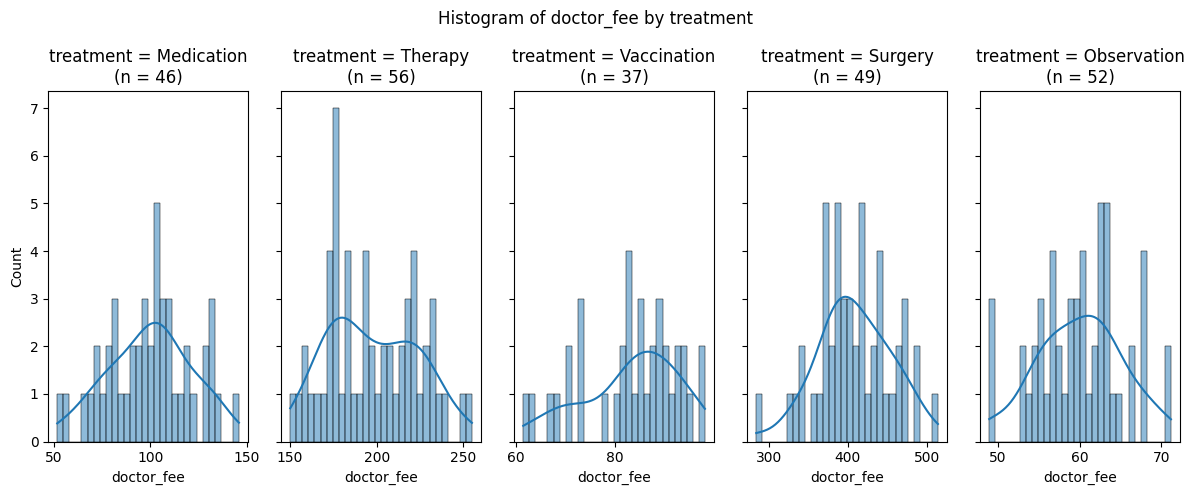

In [9]:
plot_histogram_by_group(
    df,
    group_col="treatment",
    value_col="doctor_fee",
    bins=30,
    log_scale=False   # set True if fees are very skewed
)


We can see that although the number of samples in each group is close to ~30, this still provides enough data to assess normality. The visualizations above confirm that the distributions appear approximately normal, which is consistent with our Shapiro-Wilk test results showing p-values well above our significance threshold of 0.05.

ps. we can see that treatment = Vaccination looks less normal compare to others because it has lesser sample size.

## Step 2: Formulating Our Hypothesis

Now that we've confirmed our data meets the normality assumption, we can proceed with our hypothesis test comparing surgery and therapy costs.

Based on our data, we want to test whether surgery is significantly more expensive than therapy.

**Hypotheses:**

- **Null Hypothesis (H₀)**: Surgery, on average, does not have a higher price compared to therapy. Any observed difference is due to random variation.
- **Alternative Hypothesis (H₁)**: Surgery, on average, does have a higher price compared to therapy, and this difference is not due to random variance.

We'll use a one-sided t-test (alternative="greater") since we're specifically testing whether surgery is more expensive, not just different.

In [10]:
import numpy as np
from scipy.stats import shapiro, levene, ttest_ind

def compare_two_groups(group1, group2, alpha=0.05, alternative="two-sided"):
    """
    Compare two groups with t-tests, choosing Student or Welch automatically.
    
    Parameters
    ----------
    group1, group2 : array-like
        Samples from the two groups.
        IMPORTANT: for one-sided tests, `group1` is the group in the
        direction of the alternative, e.g. alternative="greater" means
        H1: mean(group1) > mean(group2).
    alpha : float, optional
        Significance level (default 0.05).
    alternative : {"two-sided", "greater", "less"}
        - "two-sided": H1: mean1 != mean2
        - "greater"  : H1: mean1 > mean2
        - "less"     : H1: mean1 < mean2

    Steps:
    1. Check normality (Shapiro–Wilk) for each group.
    2. Check equal variance (Levene's test).
    3. If normal & equal variance -> Student's t-test.
       If normal & unequal variance -> Welch's t-test.
       If non-normal -> still run Welch, but flag that parametric test is not ideal.
    """

    # --- input prep ---
    group1 = np.asarray(group1)
    group2 = np.asarray(group2)

    if alternative not in {"two-sided", "greater", "less"}:
        raise ValueError('alternative must be "two-sided", "greater", or "less"')

    # --- 1) Normality ---
    _, p_norm1 = shapiro(group1)
    _, p_norm2 = shapiro(group2)
    normality_met = (p_norm1 > alpha) and (p_norm2 > alpha)

    # --- 2) Equal variance ---
    _, p_var = levene(group1, group2)
    equal_variance = p_var > alpha

    # --- 3) Decide which t-test (Student vs Welch) ---
    if normality_met and equal_variance:
        test_used = "student_t"
        equal_var_flag = True
    else:
        test_used = "welch_t"
        equal_var_flag = False   # Welch does not assume equal variances

    # --- 4) Run two-sided t-test first (SciPy default) ---
    t_stat, p_two_sided = ttest_ind(group1, group2, equal_var=equal_var_flag)

    # --- 5) Convert to one-sided if requested ---
    if alternative == "two-sided":
        p_final = p_two_sided
    else:
        # one-sided conversion from symmetric two-sided p-value
        if alternative == "greater":
            # H1: mean(group1) > mean(group2)
            if t_stat > 0:
                p_final = p_two_sided / 2.0
            else:
                p_final = 1.0 - p_two_sided / 2.0
        else:  # alternative == "less"
            # H1: mean(group1) < mean(group2)
            if t_stat < 0:
                p_final = p_two_sided / 2.0
            else:
                p_final = 1.0 - p_two_sided / 2.0

    reject_h0 = p_final < alpha

    results = {
        "test_used": test_used,              # 'student_t' or 'welch_t'
        "alternative": alternative,          # 'two-sided' / 'greater' / 'less'
        "t_stat": t_stat,
        "p_value": p_final,                  # p for the chosen alternative
        "p_value_two_sided": p_two_sided,    # always useful to keep
        "reject_h0": reject_h0,
        "alpha": alpha,
        "normality_met": normality_met,
        "p_norm_group1": p_norm1,
        "p_norm_group2": p_norm2,
        "equal_variance": equal_variance,
        "p_var_equal_variance": p_var,
        "parametric_recommended": normality_met,  # False => consider Mann–Whitney
    }

    return results


### Step 3: Performing the T-Test

Now let's extract the doctor fees for surgery and therapy groups and perform our statistical comparison using the function we defined above.

In [11]:
surgery_group1 = df[df['treatment'] == 'Surgery']['doctor_fee']
therapy_group2 = df[df['treatment'] == 'Therapy']['doctor_fee']

In [12]:
comparison_ttest = compare_two_groups(surgery_group1, therapy_group2, alpha=0.05, alternative="greater")
ttest_df = pd.DataFrame([comparison_ttest])

In [13]:
ttest_t_df = ttest_df.T
ttest_t_df.columns = ["values"]
ttest_t_df

,values
test_used,welch_t
alternative,greater
t_stat,27.971254
p_value,0.0
p_value_two_sided,0.0
reject_h0,True
alpha,0.05
normality_met,True
p_norm_group1,0.967362
p_norm_group2,0.147227


### Understanding the Practical Significance

Beyond statistical significance, let's calculate the actual cost difference to understand the practical significance of our findings.


In [14]:
mean_surgery = df[df["treatment"] == "Surgery"]["doctor_fee"].mean()
mean_therapy = df[df["treatment"] == "Therapy"]["doctor_fee"].mean()

ratio = round(mean_surgery / mean_therapy,2)
ratio

np.float64(2.07)

## Additional Analysis: Coefficient of Variation

Let's also examine the variability in doctor fees across different treatments using the coefficient of variation (CV), which measures relative variability independent of the mean.

In [15]:
coefficient_variation = df.groupby("treatment")["doctor_fee"].agg(["mean", "std"])
coefficient_variation["cv"] = coefficient_variation["std"] / coefficient_variation["mean"]
coefficient_variation

,mean,std,cv
treatment,,,
Medication,99.772609,21.752645,0.218022
Observation,60.066154,5.257458,0.087528
Surgery,408.425918,46.822837,0.114642
Therapy,197.695536,25.940268,0.131213
Vaccination,83.116757,9.524751,0.114595


## Summary and Conclusions

Based on our statistical analysis, we can conclude that:

1. **Cost Difference**: Surgery is approximately **2.1× more expensive** on average than therapy for fracture treatment.

2. **Statistical Significance**: This difference is **statistically significant** (p < 0.05), meaning we can reject the null hypothesis and conclude that surgery is genuinely more expensive than therapy, not just due to random variation.

3. **Practical Implications**: Patients and healthcare decision-makers should consider both the expected cost difference and the clinical outcomes when choosing between surgery and therapy for fracture treatment. While surgery may be more expensive, the decision should ultimately be based on medical necessity and expected patient outcomes, not cost alone.